In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os

In [8]:
# Constants
image_dir = './extracted_snippets'
csv_path = './extracted_snippets/snippet_records.csv'
classes = ['Calanoid_1', 'Cyclopoid_1', 'Bosmina_1', 'Herpacticoida', 'Chironomid', 'Chydoridae', 'Daphnia', 'Other']

In [9]:
# Dataset definition
class SnippetDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
        self.scaler = StandardScaler()
        self.numerical_features = self.df[['Diameter..ABD.', 'Diameter..ESD.', 'Convexity', 'Symmetry']]
        self.numerical_features = self.scaler.fit_transform(self.numerical_features)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row['Snippet.File']
        class_label = [cls for cls in classes if cls in filename][0]
        label = classes.index(class_label)
        image_path = os.path.join(self.image_dir, class_label, filename)

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        numerical_features = torch.tensor(self.numerical_features[idx], dtype=torch.float32)

        return image, numerical_features, label

In [10]:
# Model definition combining CNN and dense network for numerical features
class SnippetClassifier(nn.Module):
    def __init__(self, num_numerical_features, num_classes):
        super(SnippetClassifier, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((4, 4))
        )

        self.image_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 4 * 4, 64),
            nn.ReLU()
        )

        self.feature_fc = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 + 32, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, images, numerical_features):
        img_features = self.image_fc(self.cnn(images))
        num_features = self.feature_fc(numerical_features)
        combined = torch.cat((img_features, num_features), dim=1)
        out = self.classifier(combined)
        return out

In [11]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load and split data
snippet_df = pd.read_csv(csv_path)
train_df, temp_df = train_test_split(snippet_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_dataset = SnippetDataset(train_df, image_dir, transform=transform)
val_dataset = SnippetDataset(val_df, image_dir, transform=transform)
test_dataset = SnippetDataset(test_df, image_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

Epoch 1, Train Loss: 0.4224, Val Loss: 0.3334, Val Acc: 0.8771
Epoch 2, Train Loss: 0.3023, Val Loss: 0.2716, Val Acc: 0.9039
Epoch 3, Train Loss: 0.2615, Val Loss: 0.2651, Val Acc: 0.9075
Epoch 4, Train Loss: 0.2388, Val Loss: 0.2483, Val Acc: 0.9157
Epoch 5, Train Loss: 0.2240, Val Loss: 0.2221, Val Acc: 0.9241
Epoch 6, Train Loss: 0.2136, Val Loss: 0.2190, Val Acc: 0.9268
Epoch 7, Train Loss: 0.2066, Val Loss: 0.2151, Val Acc: 0.9286
Epoch 8, Train Loss: 0.2011, Val Loss: 0.2182, Val Acc: 0.9290
Epoch 9, Train Loss: 0.1968, Val Loss: 0.2009, Val Acc: 0.9341
Epoch 10, Train Loss: 0.1937, Val Loss: 0.2078, Val Acc: 0.9295
Epoch 11, Train Loss: 0.1905, Val Loss: 0.1973, Val Acc: 0.9356
Epoch 12, Train Loss: 0.1883, Val Loss: 0.2055, Val Acc: 0.9319
Epoch 13, Train Loss: 0.1860, Val Loss: 0.1991, Val Acc: 0.9357
Epoch 14, Train Loss: 0.1833, Val Loss: 0.2137, Val Acc: 0.9278
Epoch 15, Train Loss: 0.1811, Val Loss: 0.1967, Val Acc: 0.9352
Epoch 16, Train Loss: 0.1796, Val Loss: 0.2042, V

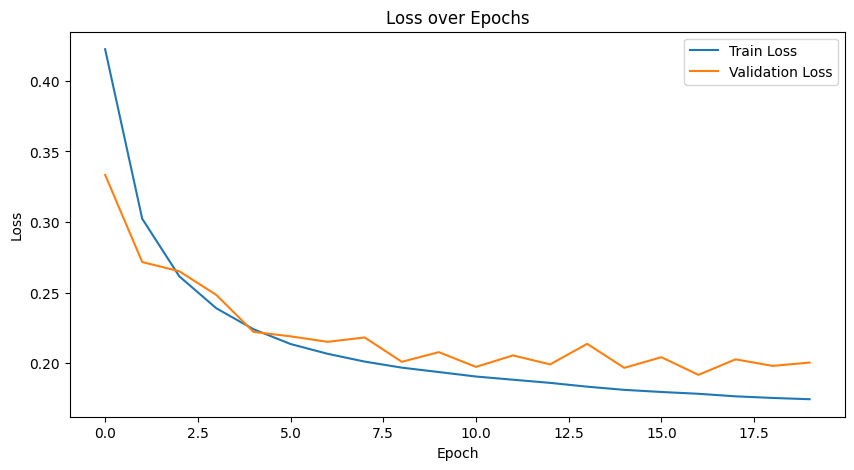

In [12]:
# Initialize model
model = SnippetClassifier(num_numerical_features=4, num_classes=len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = [], []

# Training loop
for epoch in range(20):
    model.train()
    train_loss = 0
    for images, features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images, features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for images, features, labels in val_loader:
            outputs = model(images, features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = correct / len(val_dataset)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

# Plot loss graph
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

# Save the model
torch.save(model.state_dict(), 'snippet_classifier.pth')

In [13]:
# Classification for new snippet
def classify_snippet(image_path, numerical_features, model, transform, scaler):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    numerical_features = scaler.transform([numerical_features])
    numerical_features = torch.tensor(numerical_features, dtype=torch.float32)
    output = model(image, numerical_features)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {classes[predicted.item()]}")

In [14]:
# Example usage
snippet_image_path = './extracted_snippets/Cyclopoid_1/20170510_SIMC_095_2mm_rep1_KG_data_Particle_1_Cyclopoid_1.png'
numerical_features_example = [505, 821, 0.61, 0.318]
classify_snippet(snippet_image_path, numerical_features_example, model, transform, train_dataset.scaler)


Predicted class: Cyclopoid_1


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
